In [1]:
!pip install disarray

In [2]:
import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import disarray

In [3]:
def count_jpg_files(root_dir):
    """
    Count all .jpg files in the given directory and its subdirectories
    
    Args:
        root_dir (str): Path to the root directory to start searching from
        
    Returns:
        int: total count
    """
    total_count = 0
    dir_counts = {}
    
    # Walk through all directories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        # Count jpg files in current directory
        jpg_count = len([f for f in filenames if f.lower().endswith('.jpg')])
        total_count += jpg_count
    
    return total_count

In [4]:
train_path = '/kaggle/input/multiclassoriginalimages/train_directory'
validation_path = '/kaggle/input/multiclassoriginalimages/validation_directory'
test_path = '/kaggle/input/multiclassoriginalimages/test_directory'

In [5]:
preprocess_input = tensorflow.keras.applications.mobilenet_v2.preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [6]:
batch_size = 64
train_image_gen = image_gen.flow_from_directory(train_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical')

val_image_gen = image_gen.flow_from_directory(validation_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

test_image_gen = image_gen.flow_from_directory(test_path, 
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

print(test_image_gen.class_indices)

Found 36927 images belonging to 7 classes.
Found 883 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [7]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=base_model.input, outputs=x)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [9]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

def f1_score(y_true, y_pred):
    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1_score_value = 2*((precision_value*recall_value)/(precision_value+recall_value+K.epsilon()))
    return f1_score_value

In [10]:
optimizer = Adam(0.0001)
tl_model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy, precision, recall, f1_score])

In [11]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    factor=0.5,
    patience=3,        
    mode='max',
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,       
    mode='min',
    restore_best_weights=True,
    verbose=1
)

model_chkpt = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce, early_stop]

In [12]:
total_samples = sum([5115, 5950, 5990, 5462, 5510, 4810, 4090])
class_weights = {
    0: total_samples / 5510,
    1: total_samples / 5462,
    2: total_samples / 5990,
    3: total_samples / 4090,
    4: total_samples / 5950,
    5: total_samples / 5115,
    6: total_samples / 4810
}

In [13]:
history = tl_model.fit(train_image_gen,
                       epochs=30, 
                       validation_data = val_image_gen,
                       class_weight=class_weights,
                       callbacks=callback_list)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - categorical_accuracy: 0.5124 - f1_score: 0.4509 - loss: 11.0757 - precision: 0.6632 - recall: 0.3526 - top_2_accuracy: 0.7092 - top_3_accuracy: 0.8292
Epoch 1: val_categorical_accuracy improved from -inf to 0.71914, saving model to best_model.keras
577/577 ━━━━━━━━━━━━━━━━━━━━ 395s 599ms/step - categorical_accuracy: 0.5125 - f1_score: 0.4511 - loss: 11.0723 - precision: 0.6633 - recall: 0.3528 - top_2_accuracy: 0.7094 - top_3_accuracy: 0.8293 - val_categorical_accuracy: 0.7191 - val_f1_score: 0.7115 - val_loss: 3.1110 - val_precision: 0.7435 - val_recall: 0.6833 - val_top_2_accuracy: 0.8448 - val_top_3_accuracy: 0.9094 - learning_rate: 1.0000e-04
Epoch 2/30
577/577 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - categorical_accuracy: 0.7759 - f1_score: 0.7648 - loss: 6.1454 - precision: 0.8342 - recall: 0.7074 - top_2_accuracy: 0.9185 - top_3_accuracy: 0.9720
Epoch 2: val_categorical_accuracy did not improve from 0.71914
577/577 ━━━━━━━━━━━━━━━━━━━━ 10

In [14]:
tl_model.save('val_loss_epoch.keras')

<Axes: >

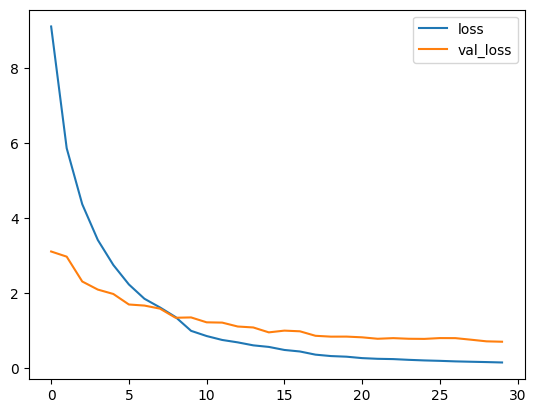

In [15]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

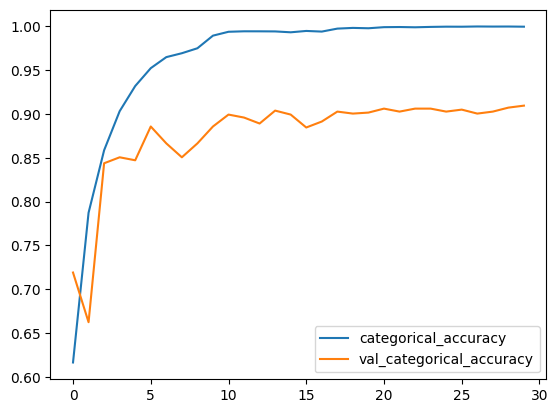

In [16]:
metrics[["categorical_accuracy","val_categorical_accuracy"]].plot()

<Figure size 640x480 with 0 Axes>

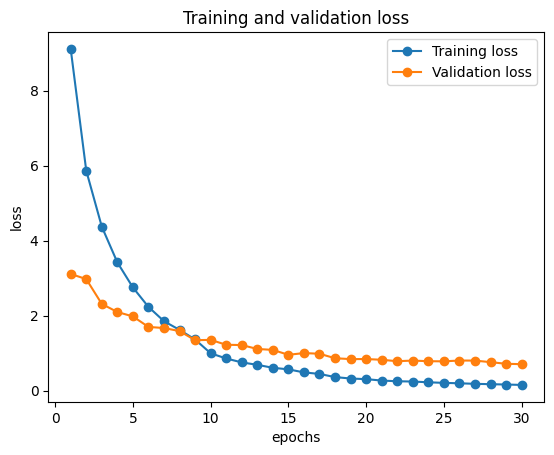

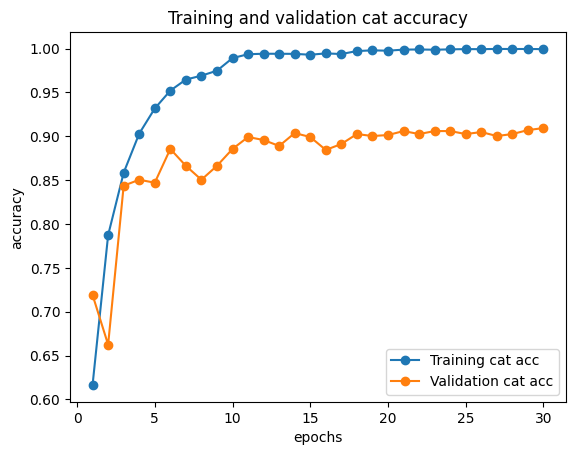

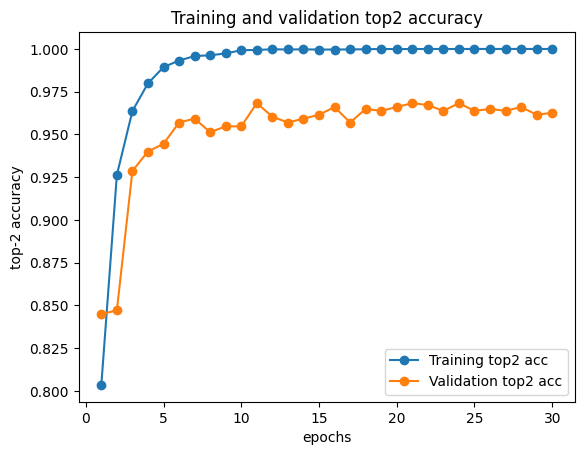

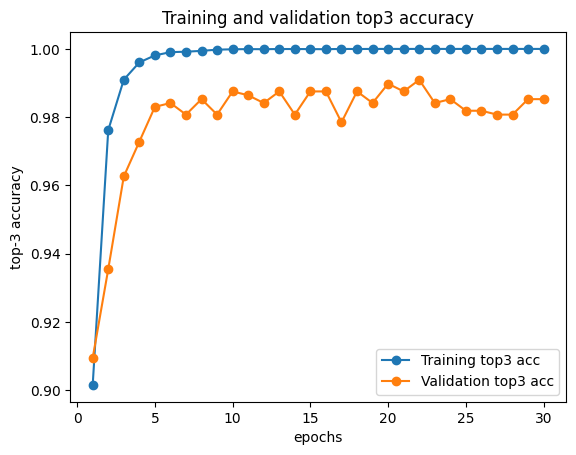

<Figure size 640x480 with 0 Axes>

In [17]:
# display the accuracy, top-2 accuracy and top-3 accuracy

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "-o", label='Training loss')
plt.plot(epochs, val_loss, "-o", label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
# plt.figure()
plt.savefig('loss.png', dpi=300)
plt.figure()

plt.plot(epochs, acc, "-o", label='Training cat acc')
plt.plot(epochs, val_acc, "-o", label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
# plt.figure()
plt.savefig('acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top2_acc, "-o", label='Training top2 acc')
plt.plot(epochs, val_top2_acc, "-o", label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-2 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top2acc.png', dpi=300)
plt.figure()

plt.plot(epochs, train_top3_acc, "-o", label='Training top3 acc')
plt.plot(epochs, val_top3_acc, "-o", label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.xlabel('epochs')
plt.ylabel('top-3 accuracy')
plt.legend()
# plt.figure()
plt.savefig('top3acc.png', dpi=300)
plt.figure()

In [24]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def plot_roc_curves_from_generator(predictions, test_labels, class_names):
    """
    Plot ROC curves for predictions from a generator-based model.
    
    Parameters:
    predictions: Raw predictions from model.predict()
    test_labels: True labels from generator.classes
    class_names: List of class names in order matching generator.class_indices
    """
    # Convert predictions to probabilities if not already
    if len(predictions.shape) == 1:  # If predictions are already argmaxed
        # Convert to one-hot
        n_classes = len(class_names)
        y_pred_proba = np.zeros((len(predictions), n_classes))
        for i, pred in enumerate(predictions):
            y_pred_proba[i, pred] = 1
    else:
        y_pred_proba = predictions
    
    # Binarize the labels
    y_test_bin = label_binarize(test_labels, classes=range(len(class_names)))
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Store AUC scores
    auc_scores = {}
    
    # Plot ROC curve for each class
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        auc_scores[class_names[i]] = roc_auc
        
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
    
    # Add diagonal reference line
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    return plt.gcf(), auc_scores

# Best Model Based on Validation Categorical Accuracy

In [25]:
tl_model.load_weights('best_model.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [26]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - categorical_accuracy: 0.8345 - f1_score: 0.8327 - loss: 1.1919 - precision: 0.8339 - recall: 0.8315 - top_2_accuracy: 0.9319 - top_3_accuracy: 0.9700
val_loss: 0.7060694694519043
val_cat_acc: 0.9093997478485107
val_top_2_acc: 0.9626274108886719
val_top_3_acc: 0.9852774739265442
val_precision: 0.9101197123527527
val_recall: 0.9070596694946289
val_f1_score 0.9085763096809387


In [27]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [28]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - categorical_accuracy: 0.8209 - f1_score: 0.8194 - loss: 1.0679 - precision: 0.8227 - recall: 0.8161 - top_2_accuracy: 0.9282 - top_3_accuracy: 0.9746
test_loss: 0.6250383853912354
test_cat_acc: 0.9075249433517456
test_top_2_acc: 0.9637352824211121
test_top_3_acc: 0.9900271892547607
test_precision: 0.9066078662872314
test_recall: 0.9040509462356567
test_f1_score 0.9053032994270325


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step

AUC Scores per class:
akiec: 0.971
bcc: 0.989
bkl: 0.976
df: 0.939
mel: 0.944
nv: 0.980
vasc: 0.995


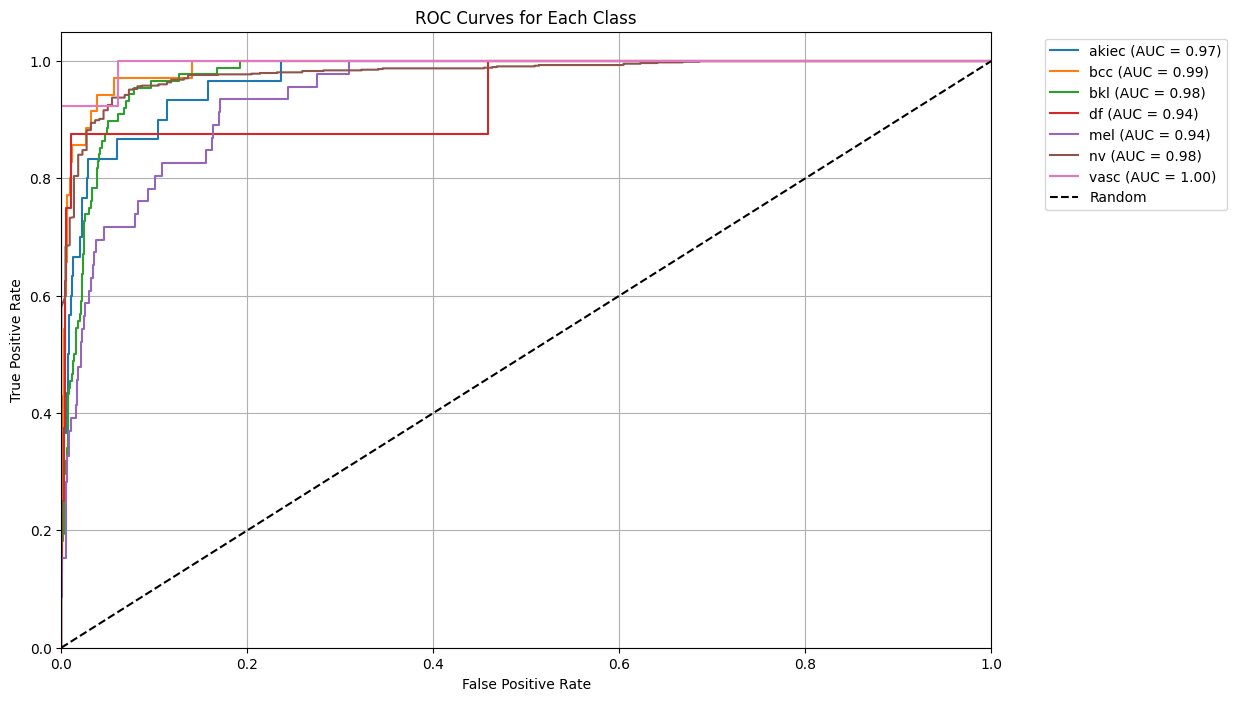

In [29]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves.png', bbox_inches='tight', dpi=300)
plt.close()

In [30]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step


Normalized confusion matrix
[[0.46666667 0.13333333 0.16666667 0.         0.13333333 0.1
  0.        ]
 [0.11428571 0.82857143 0.02857143 0.         0.         0.02857143
  0.        ]
 [0.01136364 0.02272727 0.68181818 0.01136364 0.11363636 0.15909091
  0.        ]
 [0.125      0.         0.         0.25       0.         0.625
  0.        ]
 [0.04347826 0.         0.2173913  0.         0.47826087 0.26086957
  0.        ]
 [0.0011325  0.00453001 0.01019253 0.0011325  0.00679502 0.97621744
  0.        ]
 [0.         0.         0.         0.         0.         0.07692308
  0.92307692]]


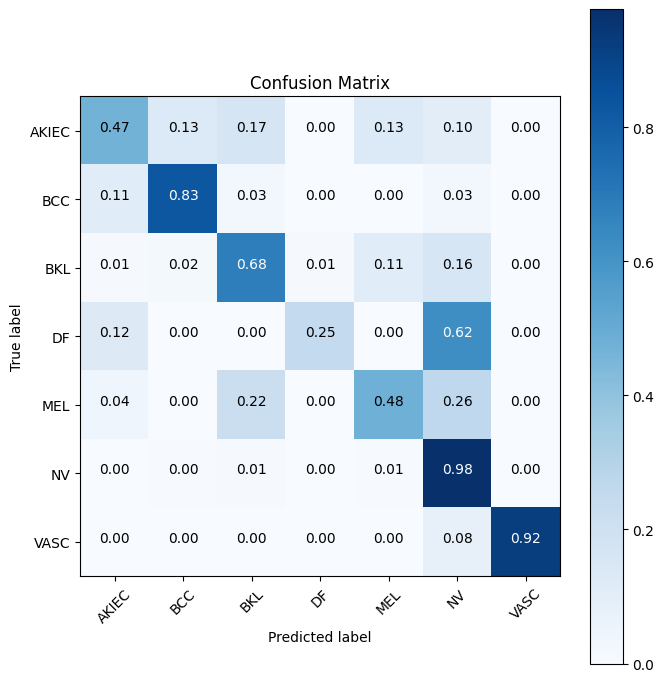

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [32]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.977335,0.985494,0.951949,0.992747,0.960109,0.948323,0.999093,0.973579
f1,0.528302,0.783784,0.693642,0.333333,0.500000,0.967996,0.960000,0.907525
false_discovery_rate,0.391304,0.256410,0.294118,0.500000,0.476190,0.040089,0.000000,0.092475
false_negative_rate,0.533333,0.171429,0.318182,0.750000,0.521739,0.023783,0.076923,0.092475
false_positive_rate,0.008388,0.009363,0.024631,0.001826,0.018921,0.163636,0.000000,0.015413
negative_predictive_value,0.985185,0.994361,0.972495,0.994540,0.977380,0.897561,0.999083,0.984587
positive_predictive_value,0.608696,0.743590,0.705882,0.500000,0.523810,0.959911,1.000000,0.907525
precision,0.608696,0.743590,0.705882,0.500000,0.523810,0.959911,1.000000,0.907525
recall,0.466667,0.828571,0.681818,0.250000,0.478261,0.976217,0.923077,0.907525
sensitivity,0.466667,0.828571,0.681818,0.250000,0.478261,0.976217,0.923077,0.907525


# Best Model Based on Validation Loss

In [33]:
tl_model.load_weights('val_loss_epoch.keras')
VALIDATION_STEPS = int(np.ceil(count_jpg_files(validation_path) / 64))

In [34]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc, val_precision, val_recall, val_f1_score = tl_model.evaluate(val_image_gen, steps=VALIDATION_STEPS)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_f1_score', val_f1_score)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - categorical_accuracy: 0.8345 - f1_score: 0.8327 - loss: 1.1919 - precision: 0.8339 - recall: 0.8315 - top_2_accuracy: 0.9319 - top_3_accuracy: 0.9700
val_loss: 0.7060694694519043
val_cat_acc: 0.9093997478485107
val_top_2_acc: 0.9626274108886719
val_top_3_acc: 0.9852774739265442
val_precision: 0.9101197123527527
val_recall: 0.9070596694946289
val_f1_score 0.9085763096809387


In [35]:
TEST_STEPS = int(np.ceil(count_jpg_files(test_path) / 64))

In [36]:
test_loss, test_cat_acc, test_top_2_acc, test_top_3_acc, test_precision, test_recall, test_f1_score = tl_model.evaluate(test_image_gen, steps=TEST_STEPS)

print('test_loss:', test_loss)
print('test_cat_acc:', test_cat_acc)
print('test_top_2_acc:', test_top_2_acc)
print('test_top_3_acc:', test_top_3_acc)
print('test_precision:', test_precision)
print('test_recall:', test_recall)
print('test_f1_score', test_f1_score)

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - categorical_accuracy: 0.8209 - f1_score: 0.8194 - loss: 1.0679 - precision: 0.8227 - recall: 0.8161 - top_2_accuracy: 0.9282 - top_3_accuracy: 0.9746
test_loss: 0.6250383853912354
test_cat_acc: 0.9075249433517456
test_top_2_acc: 0.9637352824211121
test_top_3_acc: 0.9900271892547607
test_precision: 0.9066078662872314
test_recall: 0.9040509462356567
test_f1_score 0.9053032994270325


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step

AUC Scores per class:
akiec: 0.971
bcc: 0.989
bkl: 0.976
df: 0.939
mel: 0.944
nv: 0.980
vasc: 0.995


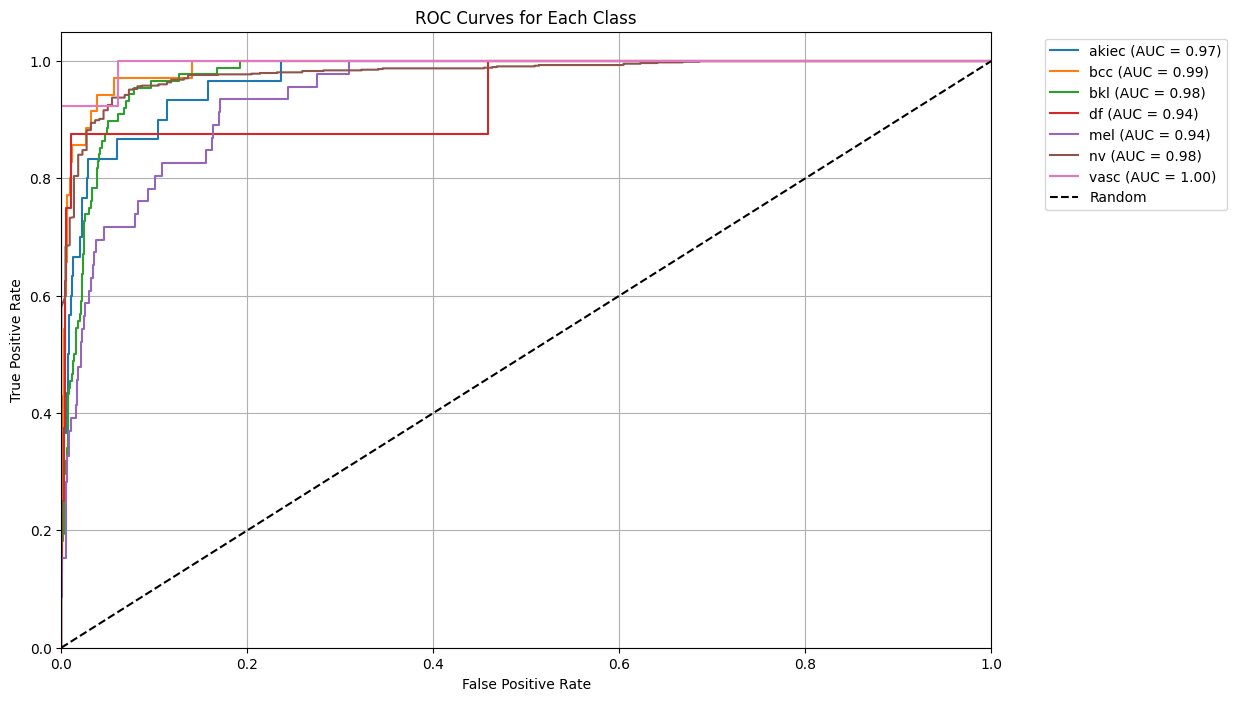

In [37]:
predictions = tl_model.predict(test_image_gen, verbose=1)
class_names = list(test_image_gen.class_indices.keys())

fig, auc_scores = plot_roc_curves_from_generator(
    predictions,
    test_image_gen.classes,
    class_names
)

print("\nAUC Scores per class:")
for class_name, score in auc_scores.items():
    print(f'{class_name}: {score:.3f}')

plt.figure()
plt.savefig('roc_curves_valloss.png', bbox_inches='tight', dpi=300)
plt.close()

In [38]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = test_image_gen.classes
cm = confusion_matrix(test_labels, predictions)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


Normalized confusion matrix
[[0.46666667 0.13333333 0.16666667 0.         0.13333333 0.1
  0.        ]
 [0.11428571 0.82857143 0.02857143 0.         0.         0.02857143
  0.        ]
 [0.01136364 0.02272727 0.68181818 0.01136364 0.11363636 0.15909091
  0.        ]
 [0.125      0.         0.         0.25       0.         0.625
  0.        ]
 [0.04347826 0.         0.2173913  0.         0.47826087 0.26086957
  0.        ]
 [0.0011325  0.00453001 0.01019253 0.0011325  0.00679502 0.97621744
  0.        ]
 [0.         0.         0.         0.         0.         0.07692308
  0.92307692]]


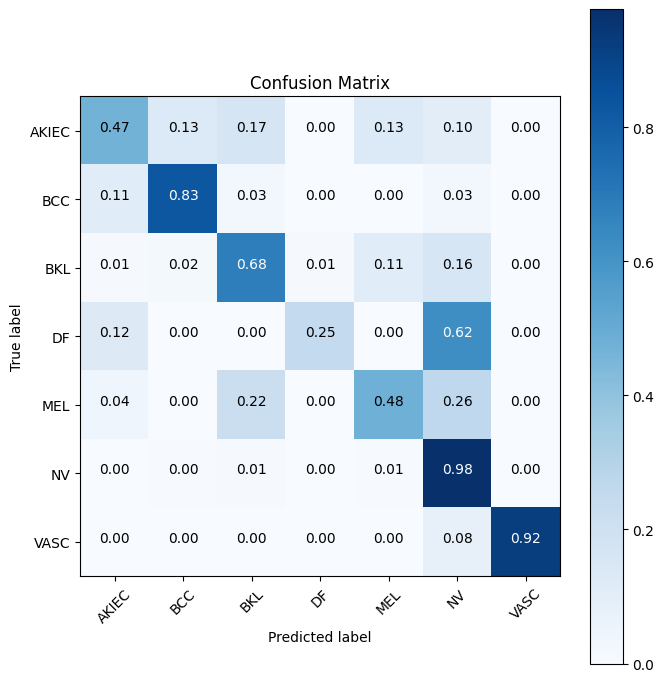

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('confusionmatrix_valloss.png', dpi=300)

    
cm_plot_labels =['AKIEC','BCC','BKL','DF','MEL','NV','VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [40]:
df = pd.DataFrame(cm, index= ['AKIEC','BCC','BKL','DF','MEL','NV','VASC'], columns=['AKIEC','BCC','BKL','DF','MEL','NV','VASC'])
df.da.export_metrics()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,micro-average
accuracy,0.977335,0.985494,0.951949,0.992747,0.960109,0.948323,0.999093,0.973579
f1,0.528302,0.783784,0.693642,0.333333,0.500000,0.967996,0.960000,0.907525
false_discovery_rate,0.391304,0.256410,0.294118,0.500000,0.476190,0.040089,0.000000,0.092475
false_negative_rate,0.533333,0.171429,0.318182,0.750000,0.521739,0.023783,0.076923,0.092475
false_positive_rate,0.008388,0.009363,0.024631,0.001826,0.018921,0.163636,0.000000,0.015413
negative_predictive_value,0.985185,0.994361,0.972495,0.994540,0.977380,0.897561,0.999083,0.984587
positive_predictive_value,0.608696,0.743590,0.705882,0.500000,0.523810,0.959911,1.000000,0.907525
precision,0.608696,0.743590,0.705882,0.500000,0.523810,0.959911,1.000000,0.907525
recall,0.466667,0.828571,0.681818,0.250000,0.478261,0.976217,0.923077,0.907525
sensitivity,0.466667,0.828571,0.681818,0.250000,0.478261,0.976217,0.923077,0.907525
